In [16]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
# Convert log-odds to probability reduction
from scipy.special import expit  # sigmoid
from matplotlib import cm
from matplotlib import colormaps


In [2]:
# Setup paths
CURRENT_DIR = Path().resolve()
BASE_DIR = CURRENT_DIR.parent if CURRENT_DIR.name == "notebooks" else CURRENT_DIR
RAW_DATA_DIR = BASE_DIR / "data" / "raw"
PROCESSED_DATA_DIR = BASE_DIR / "data" / "processed"
FIGURES_DIR = BASE_DIR / "figures"

PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)


In [3]:
#Load & Prepare Data
events = pd.read_csv(RAW_DATA_DIR / "events.csv", parse_dates=["month"])
users = pd.read_csv(RAW_DATA_DIR / "users.csv", parse_dates=["signup_date"])

# Merge and create features
df = events.merge(users[["user_id", "signup_date"]], on="user_id", how="left")
df = df.sort_values(["user_id", "month"])
df = df.groupby("user_id").first().reset_index()  # keep first month per user

# Filter modeling sample
df = df[df["subscription_type"].isin(["monthly", "annual"])]  # remove trial users
df["is_annual"] = (df["subscription_type"] == "annual").astype(int)
df["engagement"] = df["usage_time"]  # can later bin if you want segments


In [4]:
# Define model inputs
X = df[["is_annual", "engagement"]].copy()
X["engagement"] = (X["engagement"] - X["engagement"].mean()) / X["engagement"].std()  # optional standardization

y = df["churn_flag"].values


In [5]:
# Fit Bayesian logistic model (PyMC)
with pm.Model() as model:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta_annual = pm.Normal("beta_annual", mu=0, sigma=1)
    beta_engage = pm.Normal("beta_engage", mu=0, sigma=1)

    # Linear predictor
    logit_p = intercept + beta_annual * X["is_annual"] + beta_engage * X["engagement"]
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    # Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Save posterior draws
az.to_netcdf(trace, PROCESSED_DATA_DIR / "churn_model_trace.nc")


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_annual, beta_engage]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


WindowsPath('C:/Users/hayde/Desktop/bayesian-product-metrics/data/processed/churn_model_trace.nc')

In [6]:
# Summarize Posterior
az.summary(trace, var_names=["intercept", "beta_annual", "beta_engage"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-2.696,0.121,-2.919,-2.462,0.002,0.002,3462.0,3744.0,1.0
beta_annual,-1.326,0.228,-1.757,-0.906,0.003,0.003,4649.0,4172.0,1.0
beta_engage,-1.951,0.134,-2.209,-1.707,0.002,0.002,3537.0,3751.0,1.0


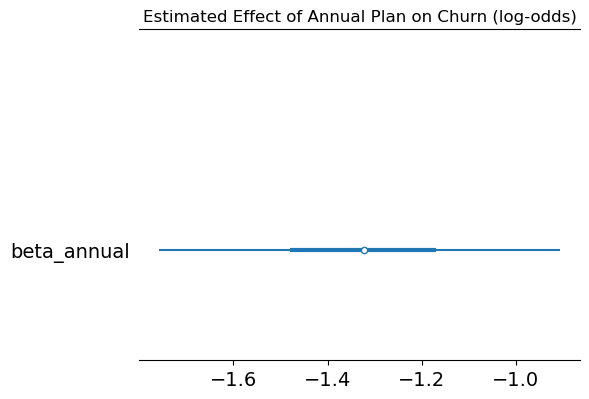

In [7]:
#Plot Posterior for treatment effect
az.plot_forest(trace, var_names=["beta_annual"], combined=True)
plt.title("Estimated Effect of Annual Plan on Churn (log-odds)")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "uplift_forest.png")
plt.show()


In [8]:
# overall summary analysis 
# Extract posterior samples
samples = trace.posterior["beta_annual"].values.flatten()
prob_reduction = (samples < 0).mean()
median_effect = np.median(samples)

print(f"Estimated log-odds reduction (annual vs monthly): {median_effect:.2f}")
print(f"Probability that annual plan reduces churn: {prob_reduction:.1%}")


Estimated log-odds reduction (annual vs monthly): -1.32
Probability that annual plan reduces churn: 100.0%


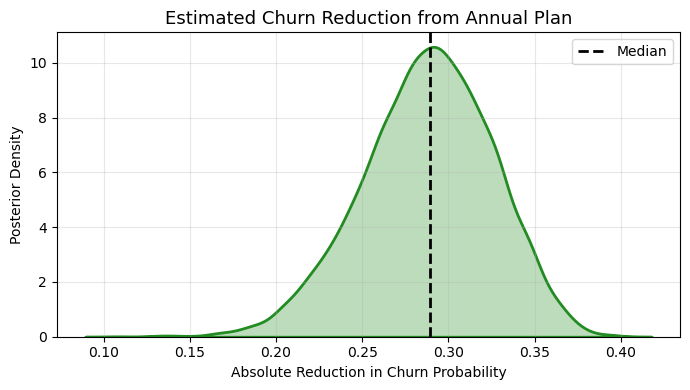

In [20]:
# Compute churn probability reduction from posterior
log_odds_samples = trace.posterior["beta_annual"].values.flatten()
prob_diff = expit(0) - expit(log_odds_samples)

# Plot with minimal, clean green styling
plt.figure(figsize=(7, 4))
sns.kdeplot(prob_diff, fill=True, color="forestgreen", alpha=0.3, linewidth=2.0)
plt.axvline(np.median(prob_diff), color="black", linestyle="--", linewidth=2.0, label="Median")

plt.title("Estimated Churn Reduction from Annual Plan", fontsize=13)
plt.xlabel("Absolute Reduction in Churn Probability")
plt.ylabel("Posterior Density")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "churn_reduction_density.png")
plt.show()